# Breaking a simple neural network

In this notebook we will take the neural net we constructed last class and try to break it. How? By messing with the data we use to train it.

My goal for this notebook is for you to understand the importance of data in training a neural network. If our data is incomplete or incorrect in some manner, then our model will be garbage (even if our cost function might look alright)

Run the cell below to import all of the python packages we will require in this notebook.

In [53]:
from pathlib import Path # internal python library for managing file paths
import requests # used to doqload files using web requests
import pickle
import gzip # used to unzip files
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch
from torch import nn
import copy
from google.colab import files
from scipy.optimize import curve_fit
import random

# Getting the MINST dataset

Run the cell below to download and unpack the MINST dataset (this is the same as last notebook).

In [2]:
data_path = Path("data")
path = data_path/"mnist" # this defines the file path as data/mnist
path.mkdir(parents=True, exist_ok=True) # this creates the folders "data" and "data/mnist"

data_url = "https://github.com/pytorch/tutorials/raw/main/_static/"
data_filename = "mnist.pkl.gz"

if not (data_path / data_filename).exists():
  content = requests.get(data_url + data_filename).content
  (data_path/data_filename).open("wb").write(content)

with gzip.open((data_path / data_filename).as_posix(), "rb") as unpacked_data:
  ((image_train, label_train), (image_valid, label_valid), _) = pickle.load(unpacked_data, encoding="latin-1")

---
# (Re-)Building a neural network


Run the code cells in this section to re-build the differnt parts of the neural network. These cells will define the cost function, the activation function, and the structure of the neural net (number of hidden layers, etc.)

In [3]:
# Define the cost function that takes in the model prediction (input) and the expected output by the model (target)
def cost_func(input, target):
   cost = torch.nn.MSELoss(reduction='sum')
   return cost(input, target)

# Define a function that takes in a digit (0-9) and creates the corresponding model target
def get_target(digits):
  target = F.one_hot(torch.tensor(digits), 10)
  return target

# Define the activation function
activation_func = F.sigmoid

# Define the structure of the neural net
class NN_Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden1 = nn.Linear(784,16) # Our input layer has 784 neurons and our first hidden layer has 16 elements
    self.hidden2 = nn.Linear(16,16) # Our second hidden layer has 16 inputs and 16 outputs
    self.output = nn.Linear(16,10) # Our output layer has 16 inputs and 10 outputs

  def forward(self, xb):
    # xb is the value of all the neurons at the current layer.
    # At the start it is a tensor with 784 elements

    # Do the matrix multiplication and then take the sigmoid of each element in the first hidden layer.
    xb = activation_func(self.hidden1(xb))
    # xb is now a tensor with 16 elements

    # Do the matrix multiplication and then take the sigmoid of each element in the second hidden layer.
    xb = activation_func(self.hidden2(xb))
    # xb is now a tensor with 16 elements

    # Do the matrix multiplication and then take the sigmoid of each element in the output layer.
    xb = activation_func(self.output(xb))
    # xb is now a tensor with 10 elements

    return xb

---
# Training the model

Run the cell below to define the training function. This is a slightly more sophisticated version of the training function we have used in the past. It takes in both the training data and the validation data. It also uses the abstract `Dataset` class and the helper class `DataLoader` from PyTorch to simplify the managment of the data and creating batches to train on.

**For those intrested in the details**: This information is not necessary for understanding anything in our class, but is here for those who are intrested in digging into the details of how python handles data structures. The `Dataset` class wraps any object that implements the [`__len__()`](https://docs.python.org/3/reference/datamodel.html#object.__len__) and [`__getitem__()`](https://docs.python.org/3/reference/datamodel.html#object.__getitem__) functions in Python. These are both examples of so-called ["magic functions"](https://rszalski.github.io/magicmethods/) in Python. They are what underly a lot of the power of Python which I would argue is the ability to basically ignore the specific type an object is. Instead we treat object logically. Is it an array like object, then `a[0]` should do something. Personally, I've never really liked the name "magic functions". What they really are is an [Interface](https://en.wikipedia.org/wiki/Interface_(object-oriented_programming) which defines a set of *behaviors*. Any class can then agree to follow and implement the interface. All of these classes can be used interchangibly (in certain contexts). The two functions we need implemented are part of [the group of magic functions](https://docs.python.org/3/reference/datamodel.html#emulating-container-types) that allow for us to iterate through a container. `__len__(self)` is what is called whenever you run `len(obj)`. `__getitem__(self, key)` is called whenever you run something like `self[key]`. Both are fundemental to the design of a data structure and are part of the interface that allows you to mostly treat all data structures the same way in Python. Isn't object oriented programming fun?

In [36]:
# We will define a function for training out model:
# epochs is the number of times we pass over the complete training set.
# batch_size is how many training examples to combine before updating the model parameters
# learning_rate controls how large of a step we take each time we update the model parameters
# data_train is the list of images we are training on (the entirety of this dataset corresponds to a single epoch)
# label_train is the list of labels corresponding to the images in data_train
# model is the model we are training

# The function will return a list containing the average cost function after each epoch
def train_model(epochs, batch_size, learning_rate, data_train, label_train, model, data_valid = None, label_valid = None):

  # Create lists to return
  cost_valid = []
  cost_train = []
  models = []

  # Create the optimizer to perform the gradient descent
  opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # Wrap the training data in a dataset
  train_ds = torch.utils.data.TensorDataset(torch.tensor(data_train), get_target(label_train))
  train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size)

  # We will repeat the training process multiple times, printing the current average of the cost function after each epoch
  for epoch in range (epochs):

    # Each iteration of this loop will evaluate the model
    # on a subset of the data containing batch_size images
    for xb, yb in train_dl:
      pred = model(xb)
      cost = cost_func(pred, yb.float())

      # Update the model parameters (i.e. train the model)
      # for this batch of data
      cost.backward()
      opt.step()
      opt.zero_grad()

    # End of batch_size loop

    xb = torch.tensor(data_train)
    yb = get_target(label_train)
    pred = model(xb)

    # calculate the average cost function
    cost = cost_func(pred, yb) / len(pred)

    xb = torch.tensor(data_valid)
    yb = get_target(label_valid)
    pred = model(xb)

    # calculate the average cost function
    cost_v = cost_func(pred, yb) / len(pred)

    print(f"After epoch {epoch} the cost function is {cost}")
    cost_valid.append(cost_v.item())
    cost_train.append(cost.item())
    models.append(copy.deepcopy(model))

  return cost_valid, cost_train, models

# Return the predicted digit from the output of the model
def get_digit(pred):
  return torch.argmax(pred, dim=0)

def accuracy(pred, xy):
  num_right = 0
  for i in range(pred.shape[0]):
    if get_digit(pred[i]) == get_digit(xy[i]):
      num_right += 1

  return num_right / pred.shape[0]

## Get a working model

Run the following code to train the model using some default hyperparameters:

After epoch 0 the cost function is 0.19530515372753143
After epoch 1 the cost function is 0.131694033741951
After epoch 2 the cost function is 0.12024848908185959
After epoch 3 the cost function is 0.10495374351739883
After epoch 4 the cost function is 0.10684888809919357
After epoch 5 the cost function is 0.10160128027200699
After epoch 6 the cost function is 0.10563848912715912
After epoch 7 the cost function is 0.1035088449716568
After epoch 8 the cost function is 0.08596884459257126
After epoch 9 the cost function is 0.08718351274728775
After epoch 10 the cost function is 0.09362450242042542
After epoch 11 the cost function is 0.08756448328495026
After epoch 12 the cost function is 0.07867836207151413
After epoch 13 the cost function is 0.07687289267778397
After epoch 14 the cost function is 0.07596025615930557
After epoch 15 the cost function is 0.07388724386692047
After epoch 16 the cost function is 0.07241076976060867
After epoch 17 the cost function is 0.07310161739587784
After

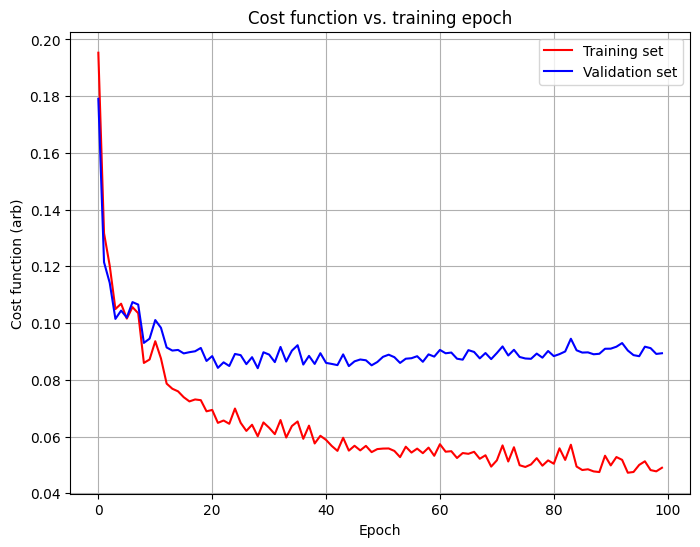

In [40]:
# Hyperparameters for training
learning_rate = 0.05
batch_size = 100
num_epochs = 100

# This will default to creating a model with random weights and biases.
torch.manual_seed(0) # This will fix it so we all get the same data
model = NN_Model()

# Train the data. Save the average cost function and the model after each epoch
costs_valid, costs, models = train_model(num_epochs, batch_size, learning_rate, image_train, label_train, model, data_valid = image_valid, label_valid=label_valid)

#torch.save(model, 'testModel.pth')
#files.download('testModel.pth')
epochs = [i for i in range(len(costs))]

# plot the cost function as a function of epoch
fig = plt.figure(figsize=(8,6))
plt.title("Cost function vs. training epoch")
plt.xlabel('Epoch')
plt.ylabel('Cost function (arb)')
plt.grid(which='both', axis='both')
plt.plot(epochs, costs, 'r-', label="Training set")
plt.plot(epochs, costs_valid, 'b-', label="Validation set")
plt.legend()
plt.show()

# When is a model done learning?

**Based on the cost curves you generated above, how does the long-term behavior of the cost function differ between the validation set and the training set?**

**Around what epoch does the validation curve level off?**

**What do you think is happening here?**


Run the code below to fit the long term behavior of the cost function for our two data sets.


The slope of the cost curve for the training data is -2.14e-04.
The slope of the cost curve for the validation data is 4.89e-05.


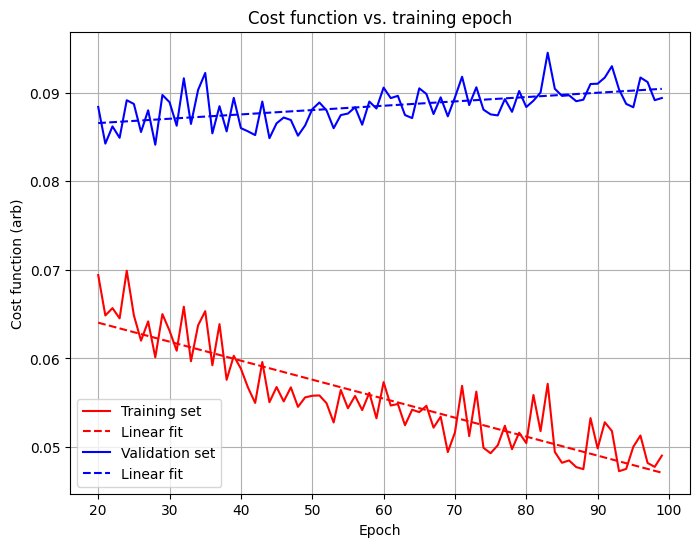

In [104]:
linear_model = lambda x,a,b: x*a + b

trunc_epoch = epochs[20:]
trunc_train = costs[20:]
trunc_valid = costs_valid[20:]

params, cov = curve_fit(linear_model, trunc_epoch, trunc_train)
model_train = linear_model(np.array(trunc_epoch), *params)
print(f"The slope of the cost curve for the training data is {params[0]:.2e}.")

params, cov = curve_fit(linear_model, trunc_epoch, trunc_valid)
model_valid = linear_model(np.array(trunc_epoch), *params)
print(f"The slope of the cost curve for the validation data is {params[0]:.2e}.")

# plot the cost function as a function of epoch
fig = plt.figure(figsize=(8,6))
plt.title("Cost function vs. training epoch")
plt.xlabel('Epoch')
plt.ylabel('Cost function (arb)')
plt.grid(which='both', axis='both')
plt.plot(trunc_epoch, costs[20:], 'r-', label="Training set")
plt.plot(trunc_epoch, model_train, 'r--', label="Linear fit")
plt.plot(epochs[20:], costs_valid[20:], 'b-', label="Validation set")
plt.plot(trunc_epoch, model_valid, 'b--', label="Linear fit")
plt.legend()
plt.show()

**What does it mean for the validity of our model that the slope for the training set is negative and the slope for the validation set is positive?**

# Training with bad data

Machine learning models are only as good as the data they are given. Suppose we where to shuffle of the labels in our training set. That is each image in our training set is assigned to a random number as a label.

**What do you think the cost curves will look like for the training and validation sets?**


After writing your prediction, run the following code to find out.

In [61]:
# Hyperparameters for training
learning_rate = 0.05
batch_size = 100
num_epochs = 100

# This will default to creating a model with random weights and biases.
torch.manual_seed(0) # This will fix it so we all get the same data
model = NN_Model()

label_sh = copy.deepcopy(label_train)
random.shuffle(label_sh)

# Train the data. Save the average cost function and the model after each epoch
costs_valid_sh, costs_sh, models_sh = train_model(num_epochs, batch_size, learning_rate, image_train, label_sh, model, data_valid = image_valid, label_valid=label_valid)
epochs_sh = [i for i in range(len(costs_sh))]


After epoch 0 the cost function is 0.9002063870429993
After epoch 1 the cost function is 0.9001520872116089
After epoch 2 the cost function is 0.9001158475875854
After epoch 3 the cost function is 0.9000884890556335
After epoch 4 the cost function is 0.9000665545463562
After epoch 5 the cost function is 0.9000477194786072
After epoch 6 the cost function is 0.9000310897827148
After epoch 7 the cost function is 0.9000152349472046
After epoch 8 the cost function is 0.8999996185302734
After epoch 9 the cost function is 0.8999834656715393
After epoch 10 the cost function is 0.8999660015106201
After epoch 11 the cost function is 0.8999471068382263
After epoch 12 the cost function is 0.8999269008636475
After epoch 13 the cost function is 0.899905800819397
After epoch 14 the cost function is 0.8998834490776062
After epoch 15 the cost function is 0.8998595476150513
After epoch 16 the cost function is 0.8998332619667053
After epoch 17 the cost function is 0.8998045325279236
After epoch 18 the co

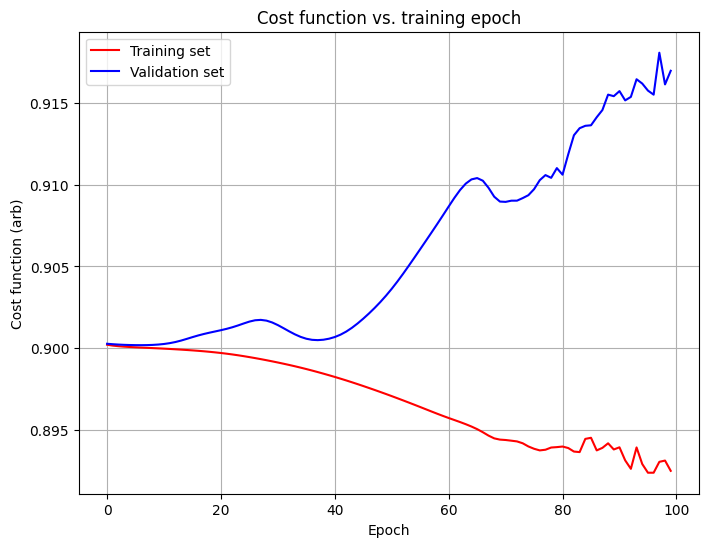

In [81]:

# plot the cost function as a function of epoch
fig = plt.figure(figsize=(8,6))
plt.title("Cost function vs. training epoch")
plt.xlabel('Epoch')
plt.ylabel('Cost function (arb)')
plt.grid(which='both', axis='both')
plt.plot(epochs_sh, costs_sh, 'r-', label="Training set")
plt.plot(epochs_sh, costs_valid_sh, 'b-', label="Validation set")
plt.legend()
plt.show()

**What is the long term behavior for both cost curves?**

**How do the cost curves differ from when we are training with good data?**


Let's look for a second at the accuracy as a function of epoch. It's a little easier to interpate. **If our model was just guessing, what would the expected accuracy of the model be?**

After making your prediction, run the two code cells below to calcualte and plot accuracy vs epoch (it'll take a bit, there is a lot of data to churn through, if you want to edit the plot just run the second cell).

In [121]:
target = get_target(label_sh)
target_valid = get_target(label_valid)
acc_train = []
acc_valid = []
for model, epoch in zip(models_sh, range(len(models))):
  if epoch % 10 == 0:
    print("On epoch ", epoch, " of ", len(models))

  pred = model(torch.tensor(image_train))
  acc_train.append(accuracy(pred, target))


  pred = model(torch.tensor(image_valid))
  acc_valid.append(accuracy(pred, target_valid))


On epoch  0  of  100
On epoch  10  of  100
On epoch  20  of  100
On epoch  30  of  100
On epoch  40  of  100
On epoch  50  of  100
On epoch  60  of  100
On epoch  70  of  100
On epoch  80  of  100


The carrying capacity of the cost curve for the training data is 14.40%.


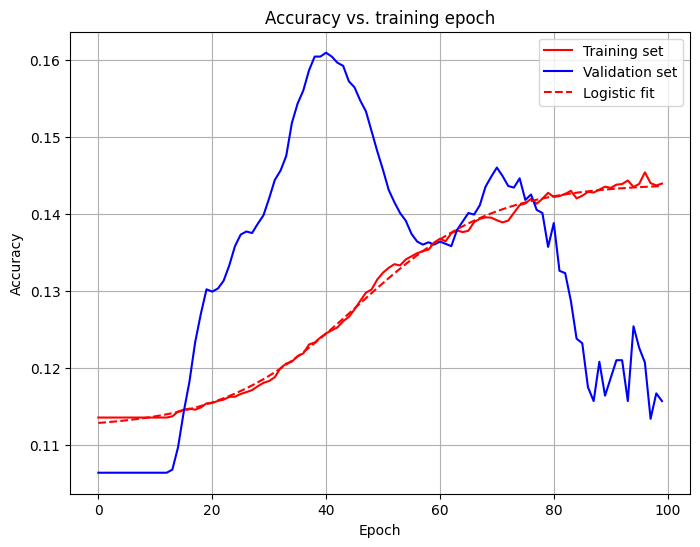

In [123]:
log_model = lambda x, a, b, c, d: a/(1+np.exp(-b*(x-c))) + d

trunc_epoch = epochs[0:]
trunc_train = costs_sh[0:]
trunc_valid = costs_valid_sh[0:]

params, cov = curve_fit(log_model, trunc_epoch, acc_train, p0=[.03, 1, 45, .12])
model_train = log_model(np.array(trunc_epoch), *params)
print(f"The carrying capacity of the cost curve for the training data is {(params[0]+params[3])*100:.2f}%.")

params, cov = curve_fit(linear_model, trunc_epoch, acc_valid)
model_valid = linear_model(np.array(trunc_epoch), *params)
#print(f"The slope of the cost curve for the validation data is {params[0]:.2e}.")



# plot the cost function as a function of epoch
fig = plt.figure(figsize=(8,6))
plt.title("Accuracy vs. training epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(which='both', axis='both')
plt.plot(epochs_sh, acc_train, 'r-', label="Training set")
plt.plot(epochs_sh, acc_valid, 'b-', label="Validation set")
plt.plot(epochs_sh, model_train, 'r--', label="Logistic fit")
#plt.plot(epochs_sh, model_valid, 'b--', label="Validation set")
plt.legend()
plt.show()

**What do you notice about the accuracy? Is one dataset better than random? Is one dataset worse than random?**

**Why do you think the accuracy for the trainins set is leveling off? It is fit quite well by a logisitic function.**

**What do you think would happen if we were to only train on $100$ examples instead of $50,000$ (with the wrong labels)?**


The code below will train a series of models on only 100 events with the labels shuffled.

After epoch 0 the cost function is 0.9732080101966858
After epoch 1 the cost function is 0.9679574370384216
After epoch 2 the cost function is 0.9617587327957153
After epoch 3 the cost function is 0.9549980759620667
After epoch 4 the cost function is 0.9483495354652405
After epoch 5 the cost function is 0.9426435828208923
After epoch 6 the cost function is 0.9384831786155701
After epoch 7 the cost function is 0.9352517127990723
After epoch 8 the cost function is 0.9318231344223022
After epoch 9 the cost function is 0.927724301815033
After epoch 10 the cost function is 0.9228343963623047
After epoch 11 the cost function is 0.9171881675720215
After epoch 12 the cost function is 0.9110476970672607
After epoch 13 the cost function is 0.9049617648124695
After epoch 14 the cost function is 0.8996288776397705
After epoch 15 the cost function is 0.8955430388450623
After epoch 16 the cost function is 0.8927392363548279
After epoch 17 the cost function is 0.890920102596283
After epoch 18 the cos

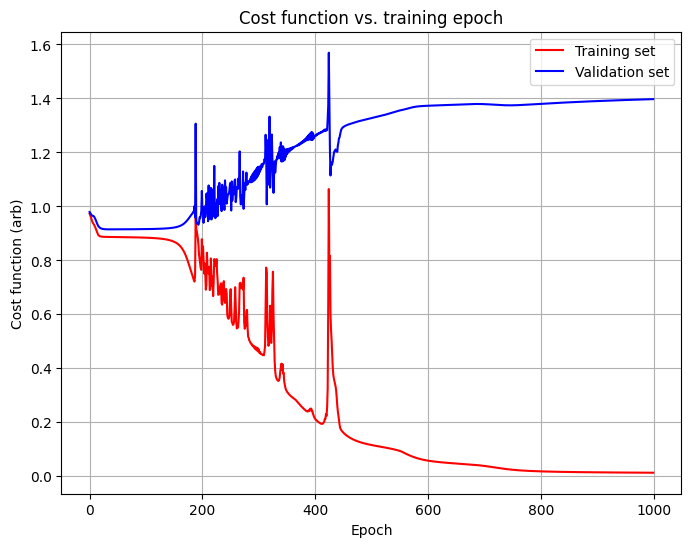

In [107]:
# Hyperparameters for training
learning_rate = 0.05
batch_size = 100
num_epochs = 1000

# This will default to creating a model with random weights and biases.
torch.manual_seed(0) # This will fix it so we all get the same data
model = NN_Model()

label_100 = label_sh[:100]
data_100 = image_train[:100]

# Train the data. Save the average cost function and the model after each epoch
costs_valid_100, costs_100, models_100 = train_model(num_epochs, batch_size, learning_rate, data_100, label_100, model, data_valid = image_valid, label_valid=label_valid)
epochs_100 = [i for i in range(len(costs_100))]

# plot the cost function as a function of epoch
fig = plt.figure(figsize=(8,6))
plt.title("Cost function vs. training epoch")
plt.xlabel('Epoch')
plt.ylabel('Cost function (arb)')
plt.grid(which='both', axis='both')
plt.plot(epochs_100, costs_100, 'r-', label="Training set")
plt.plot(epochs_100, costs_valid_100, 'b-', label="Validation set")
plt.legend()
plt.show()


Let's take a look at the accuracy as well. Once again this will take while to run. While it's running, make a prediction for what you think the accuracy of the training data will be.

**What is the highest accuracy you think we can achieve for the training data?**

**At that same time, what do you think the accuracy of the validation set will be?**

In [124]:
target = get_target(label_100)
target_valid = get_target(label_valid)
acc_train_100 = []
acc_valid_100 = []
for model, epoch in zip(models_100, range(len(models_100))):
  if epoch % 10 == 0:
    print("On epoch ", epoch, " of ", len(models_100))

  pred = model(torch.tensor(image_train[:100]))
  acc_train_100.append(accuracy(pred, target))


  pred = model(torch.tensor(image_valid))
  acc_valid_100.append(accuracy(pred, target_valid))
print("Done calculating accuracy. Run next cell for plot")

On epoch  0  of  1000
On epoch  10  of  1000
On epoch  20  of  1000
On epoch  30  of  1000
On epoch  40  of  1000
On epoch  50  of  1000
On epoch  60  of  1000
On epoch  70  of  1000
On epoch  80  of  1000
On epoch  90  of  1000
On epoch  100  of  1000
On epoch  110  of  1000
On epoch  120  of  1000
On epoch  130  of  1000
On epoch  140  of  1000
On epoch  150  of  1000
On epoch  160  of  1000
On epoch  170  of  1000
On epoch  180  of  1000
On epoch  190  of  1000
On epoch  200  of  1000
On epoch  210  of  1000
On epoch  220  of  1000
On epoch  230  of  1000
On epoch  240  of  1000
On epoch  250  of  1000
On epoch  260  of  1000
On epoch  270  of  1000
On epoch  280  of  1000
On epoch  290  of  1000
On epoch  300  of  1000
On epoch  310  of  1000
On epoch  320  of  1000
On epoch  330  of  1000
On epoch  340  of  1000
On epoch  350  of  1000
On epoch  360  of  1000
On epoch  370  of  1000
On epoch  380  of  1000
On epoch  390  of  1000
On epoch  400  of  1000
On epoch  410  of  1000
On 

The carrying capacity of the cost curve for the training data is 0.99.


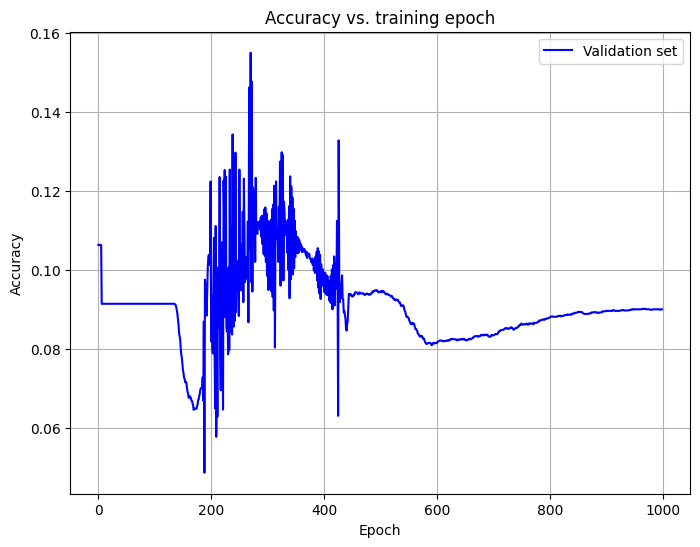

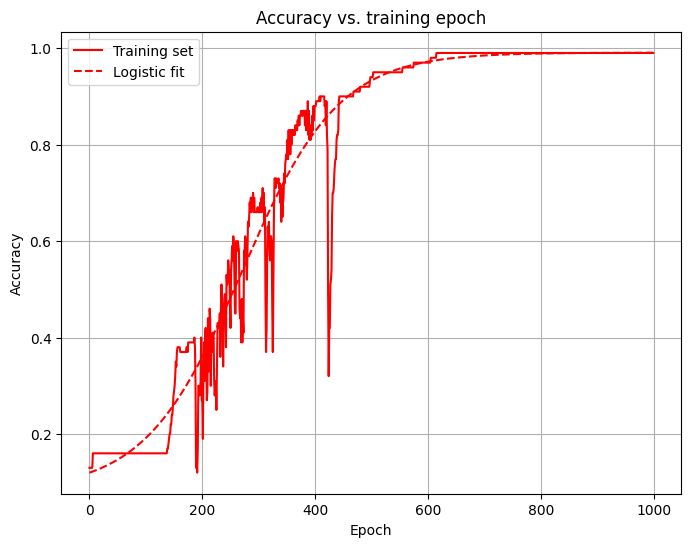

In [119]:
log_model = lambda x, a, b, c, d: a/(1+np.exp(-b*(x-c))) + d

trunc_epoch = epochs_100[0:]
trunc_train = costs_100[0:]
trunc_valid = costs_valid_100[0:]

params, cov = curve_fit(log_model, trunc_epoch, acc_train_100, p0=[.9, 1, 40, .12])
model_train = log_model(np.array(trunc_epoch), *params)
print(f"The carrying capacity of the cost curve for the training data is {(params[0]+params[3])*100:.2f}%.")

params, cov = curve_fit(linear_model, trunc_epoch, acc_valid_100)
model_valid = linear_model(np.array(trunc_epoch), *params)
#print(f"The slope of the cost curve for the validation data is {params[0]:.2e}.")


# plot the cost function as a function of epoch
fig = plt.figure(figsize=(8,6))
plt.title("Accuracy vs. training epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(which='both', axis='both')
#plt.plot(epochs_100, acc_train_100, 'r-', label="Training set")
plt.plot(epochs_100, acc_valid_100, 'b-', label="Validation set")
#plt.plot(epochs_100, model_train, 'r--', label="Logistic fit")
#plt.plot(epochs_100, model_valid, 'b--', label="Validation set")
plt.legend()
plt.show()

fig = plt.figure(figsize=(8,6))
plt.title("Accuracy vs. training epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(which='both', axis='both')
plt.plot(epochs_100, acc_train_100, 'r-', label="Training set")
#plt.plot(epochs_100, acc_valid_100, 'b-', label="Validation set")
plt.plot(epochs_100, model_train, 'r--', label="Logistic fit")
#plt.plot(epochs_100, model_valid, 'b--', label="Validation set")
plt.legend()
plt.show()

**Compare your prediction to what you saw in the above plot.**

**How does the maximum accuracy of the training set with 100 example? With 50,000 examples?**

**Why can our model memorize the smaller training set, but not the larger training set? How could we modify our model so it could learn the full training set?**

**Why do you think the accuracy on the validation set is improving beween epoch 600 and 1000? What accuracy is it trending towards?**

# Bad data, bad model

We just trained a model that achieved 99% accuracy! That right there with the worlds best models, right? There's just one problem. It performs worse then guessing on any image it hasn't seen before. Not the most useful model, is it? This is an exmaple of **over-training** or **over-fitting**. We hyper-specalize our model to the point of uselessness. We say this even before we taught our model to memorize 100 images. In our model at the start of this notebook the cost function of the validation set began creeping up over time even as the cost function of the training set continued to fall. That's a clear sign that we began to over-fit our model.

# Universality of Neural Networks
In any machine learning model, the data used to train it is the *most* important component. [The Universal Approximation Theorem](https://towardsdatascience.com/neural-networks-and-the-universal-approximation-theorem-8a389a33d30a) guarantees that a neural network (with enough complexity) can be used to approximate *any* function, regardless of the number of inputs or outputs. Assuming of course, we have enough examples of the function to show the neural net.

This fact, that you need data to train any useful model is one of the largest forces driving the economy. Especially in the tech sector. Any company that provides a free service on the internet (social media, Google, etc.) is probably in the buisness of collecting and using user data. This is often the driving force (or at least *a* driving force) behind decisions around availability of data through APIs. In the past year, [Twitter](https://www.theverge.com/2023/2/2/23582615/twitter-removing-free-api-developer-apps-price-announcement) and [Reddit](https://en.wikipedia.org/wiki/2023_Reddit_API_controversy) both made large changes to their API pricing structures. Reddit's CEO has [talked explicity](https://www.nytimes.com/2023/04/18/technology/reddit-ai-openai-google.html) about how the change is motivated by a desire to profit off of the data (post and comments on reddit) that is being used to train large language models like the one that underlies ChatGPT.

# Homework

Pick some situation where you encounter (or thing you encounter) some machine learning based model or algorithm. Suppose you were to design that algorithm:

1. What is the algorithm doing?
1. What is the cost function for the algorithm?
1. What data would you need to train this model? What are the inputs and outputs of the model?